<a href="https://colab.research.google.com/github/sjsjlee/study_financial_data_analysis/blob/main/KNN_S%26P_investing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Import Libraries

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 5.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=a2aaaa00f4aa774f24bfdb520393dfb8a249b4ac1e5db8a10125fc9e6c8fc1ba
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import yfinance as yf
from pandas_datareader import data as pdr
pd.core.common.is_list_like = pd.api.types.is_list_like
yf.pdr_override()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#1. Get Data

##1-1. get data from yahoo finance

In [ ]:
spy_df = pdr.get_data_yahoo('SPY', '2012-01-01', '2021-07-31')
spy_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,105.985199,193697900
2012-01-04,127.199997,127.809998,126.709999,127.699997,106.151421,127186500
2012-01-05,127.010002,128.229996,126.430000,128.039993,106.434067,173895000
2012-01-06,128.199997,128.220001,127.290001,127.709999,106.159752,148050000
2012-01-09,128.000000,128.179993,127.410004,128.020004,106.417435,99530200
...,...,...,...,...,...,...
2021-07-26,439.309998,441.029999,439.260010,441.019989,441.019989,43719200
2021-07-27,439.910004,439.940002,435.989990,439.010010,439.010010,67397100
2021-07-28,439.679993,440.299988,437.309998,438.829987,438.829987,52472400


In [ ]:
spy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2410 entries, 2012-01-03 to 2021-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2410 non-null   float64
 1   High       2410 non-null   float64
 2   Low        2410 non-null   float64
 3   Close      2410 non-null   float64
 4   Adj Close  2410 non-null   float64
 5   Volume     2410 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 131.8 KB


In [ ]:
spy_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2.410000e+03
mean,237.817124,238.992481,236.535772,237.861900,221.121609,1.027442e+08
std,71.309388,71.693663,70.869372,71.314943,77.991543,5.102136e+07
min,127.010002,127.809998,126.430000,127.500000,105.985199,2.027000e+07
25%,188.419998,189.160000,187.165001,188.122498,165.114388,6.599955e+07
50%,217.384995,218.209999,216.590004,217.514999,198.493622,9.071610e+07
75%,282.582504,284.157501,280.679993,282.757500,270.377373,1.266668e+08
max,439.910004,441.799988,439.809998,441.019989,441.019989,5.072443e+08


##1-2. Feature&Target data

In [ ]:
tmp_df = spy_df.copy()
print(tmp_df.shape)
tmp_df.head()

(2410, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,105.985199,193697900
2012-01-04,127.199997,127.809998,126.709999,127.699997,106.151421,127186500
2012-01-05,127.010002,128.229996,126.430000,128.039993,106.434067,173895000
2012-01-06,128.199997,128.220001,127.290001,127.709999,106.159752,148050000
2012-01-09,128.000000,128.179993,127.410004,128.020004,106.417435,99530200


In [ ]:
tmp_df = tmp_df[tmp_df.columns[:4]]

In [ ]:
#변동성 지표1 : 시초가-종가

tmp_df['OC'] = tmp_df['Open'] - tmp_df['Close']

In [ ]:
# 변동성 지표2 : 고가-저가

tmp_df['HL']= tmp_df['High'] - tmp_df['Low']

In [ ]:
#feature 데이터셋

x_val = tmp_df[['OC', 'HL']]
x_val

,OC,HL
Date,,
2012-01-03,0.260002,0.950005
2012-01-04,-0.500000,1.099998
2012-01-05,-1.029991,1.799995
2012-01-06,0.489998,0.930000
2012-01-09,-0.020004,0.769989
...,...,...
2021-07-26,-1.709991,1.769989
2021-07-27,0.899994,3.950012
2021-07-28,0.850006,2.989990


In [ ]:
#y_val => 타겟 데이터셋
#np.where(조건, 참일경우값, 거짓일경우값)

y_val = np.where(tmp_df['Close'].shift(-1) > tmp_df['Open'].shift(-1), 1, -1)
y_val

array([ 1,  1, -1, ...,  1,  1, -1])

In [ ]:
# shift 사용시 그 다음날 값 보여줌

mp_df['Close'].shift(-1)

Date
2012-01-03    127.699997
2012-01-04    128.039993
2012-01-05    127.709999
2012-01-06    128.020004
2012-01-09    129.130005
                 ...    
2021-07-26    439.010010
2021-07-27    438.829987
2021-07-28    440.649994
2021-07-29    438.510010
2021-07-30           NaN
Name: Close, Length: 2410, dtype: float64

In [ ]:
# 내일의 종가 > 내일의 시가
# 다음날 지수가 오르는 지 확인하기 위해서 사용

tmp_df['Close'].shift(-1) > tmp_df['Open'].shift(-1)

Date
2012-01-03     True
2012-01-04     True
2012-01-05    False
2012-01-06     True
2012-01-09    False
              ...  
2021-07-26    False
2021-07-27    False
2021-07-28     True
2021-07-29     True
2021-07-30    False
Length: 2410, dtype: bool

##1-3. Visualiztion Feature data

In [ ]:
x_min, x_max = x_val['OC'].min() - .5,  x_val['OC'].max() + .5
y_min, y_max = x_val['HL'].min() - .5, x_val['HL'].max() + .5

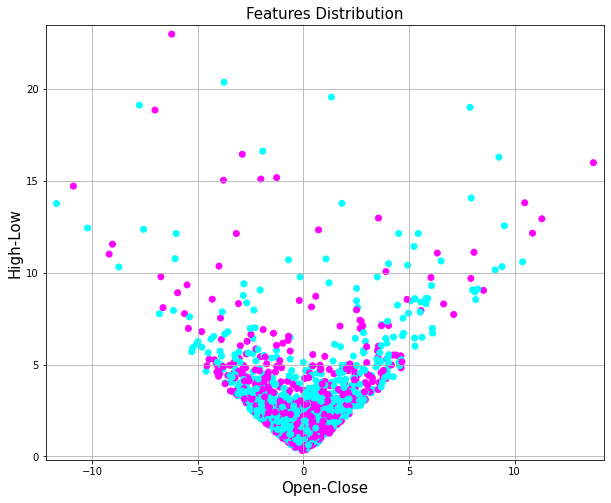

In [ ]:
# 산포도

plt.figure(figsize=(10, 8))

# plt.scatter(x축 = 'OC', y축 = 'HL')
# https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.Colormap.html#matplotlib.colors.Colormap

plt.scatter(x_val['OC'], x_val['HL'], c=y_val, cmap = 'cool_r') #clormap 에러 뜨게 하면 colormap 종류들 볼 수 있음
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title('Features Distribution', fontsize = 15)
plt.xlabel('Open-Close', fontsize = 15)
plt.ylabel('High-Low', fontsize = 15)
plt.grid()

plt.show()

##1-4. Standardization

###1-4-1. 표준화(Standardization)

- 평균 == 0, 표준편차 == 1


In [ ]:
standardizer = StandardScaler()

In [ ]:
standardizer

StandardScaler(copy=True, with_mean=True, with_std=True)

### 1-4-2. 정규화(Normarlization)

- 모든 데이터를 0~1로 범주화

In [ ]:
x_val_standardized = standardizer.fit_transform(x_val)
x_val_standardized

array([[ 0.16381711, -0.66843675],
       [-0.24468142, -0.60189324],
       [-0.52954984, -0.29134559],
       ...,
       [ 0.48094221,  0.23658542],
       [-0.42204807, -0.20705602],
       [-0.29843436, -0.07395546]])

In [ ]:
print(round(x_val_standardized.mean()))
print(x_val_standardized.std())

0
1.0


# 2. Split into Train&Test data


In [ ]:
# shuffle -> 디폴트값: True, but 여기선 시계열이므로 날짜 순서가 상관이 있기 때문에 섞으면 안됨

x_train, x_test, y_train, y_test = train_test_split(
    x_val_standardized, y_val,
    test_size = 0.3, random_state = 42, shuffle = False
)

# 3. Train Model Object

## 3-1. Training

In [ ]:
train_accuracy = []
test_accuracy = []

for n in tqdm(range(1, 15)) :

  clf = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
  clf.fit(x_train, y_train)
  pred = clf.predict(x_test)

#자기가 학습한 데이터에 대한 score를 쌓아나감
  train_accuracy.append(clf.score(x_train, y_train))
  test_accuracy.append((pred == y_test).mean())

100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


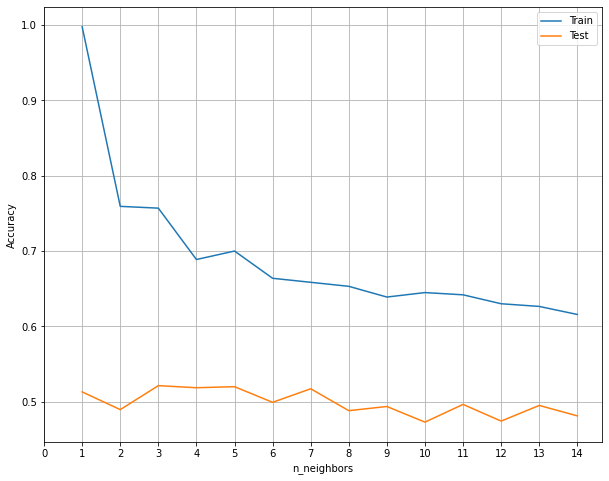

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 15), train_accuracy, label = 'Train')
plt.plot(range(1, 15), test_accuracy, label = 'Test')

plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks(range(0, 15))

plt.legend()
plt.grid()
plt.show()

# train 데이터 셋은 이웃의 수가 높아질 수록 accuracy가 떨어지고 있음
# test 데이터 셋의 accuracy는 3과 7에서 높은것으로 보임

## 3-2. Model Performance

In [ ]:
# n_neighbors값 조정하면서 test 데이터 셋 accuracy 가장 높은 지점 찾기

clf = KNeighborsClassifier(n_jobs = -1, n_neighbors=3)
clf.fit(x_train, y_train)
print(accuracy_score(y_test, clf.predict(x_test)))

# 과거의 통계로 봤을 때 54% 정도면 준수한 수준의 score임

0.5214384508990318
